In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import names
from nltk.metrics.scores import precision, recall
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def team_features(team):
    info = {}
    for i in range(1,17):
        info[f"seed: {i}"] = False
        if int(team.SEED) == i:
          info[f"seed: {i}"] = True
    info["Win/Loss ratio"] = team.W / (team.G - team.W)
    info["2-point rate"] = team["2P_O"]
    info["3-point rate"] = team["3P_O"]
    
    return info

In [3]:
df = pd.read_csv("cbb.csv")
df = df.dropna()
df['SEED'] = df['SEED'].astype(str).str.replace('$', '',regex=True).astype('float')
df['3P_O'] = df['3P_O'].astype(str).str.replace('$', '',regex=True).astype('float')
df['2P_O'] = df['2P_O'].astype(str).str.replace('$', '',regex=True).astype('float')
df['W'] = df['W'].astype(str).str.replace('$', '',regex=True).astype('float')

In [4]:
data = []
for i in range(df.TEAM.size):
    curr = df.iloc[i]
    if curr.POSTSEASON != "NA" and curr.SEED != "NA":
      oneWin = "First round out" if curr.POSTSEASON in ["R68", "R64"] else "Past first round"  
      data.append((team_features(curr), oneWin))

In [5]:
train_set, test_set = train_test_split(data, test_size=0.1, random_state=43)
print(train_set[0])

classifier = nltk.NaiveBayesClassifier.train(train_set)

({'seed: 1': False, 'seed: 2': False, 'seed: 3': False, 'seed: 4': False, 'seed: 5': False, 'seed: 6': False, 'seed: 7': False, 'seed: 8': False, 'seed: 9': False, 'seed: 10': False, 'seed: 11': False, 'seed: 12': True, 'seed: 13': False, 'seed: 14': False, 'seed: 15': False, 'seed: 16': False, 'Win/Loss ratio': 2.3, '2-point rate': 54.4, '3-point rate': 32.6}, 'First round out')


In [6]:
y_true = list(list(zip(*test_set))[1])
test_features = list(list(zip(*test_set))[0])
y_predict = [classifier.classify(features) for features in test_features]

In [7]:
(p,r,f,s) = precision_recall_fscore_support(y_true, y_predict)
print(p,r,f,s)

classifier.show_most_informative_features(15)

[0.9047619  0.77777778] [0.76       0.91304348] [0.82608696 0.84      ] [25 23]
Most Informative Features
                seed: 16 = True           First  : Past f =     21.6 : 1.0
                 seed: 2 = True           Past f : First  =     10.2 : 1.0
                seed: 15 = True           First  : Past f =      9.4 : 1.0
                 seed: 3 = True           Past f : First  =      9.3 : 1.0
                 seed: 4 = True           Past f : First  =      8.8 : 1.0
          Win/Loss ratio = 1.75           First  : Past f =      8.2 : 1.0
          Win/Loss ratio = 2.6            Past f : First  =      6.2 : 1.0
            3-point rate = 36.5           Past f : First  =      5.5 : 1.0
            2-point rate = 52.9           Past f : First  =      5.5 : 1.0
          Win/Loss ratio = 3.125          First  : Past f =      4.6 : 1.0
            2-point rate = 49.2           First  : Past f =      4.5 : 1.0
            3-point rate = 35.3           Past f : First  =      4.0 

In [8]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=36)

# Modify the feature matrix to have 2D array shape
X_train = [list(features.values()) for features, label in train_set]
y_train = [label for features, label in train_set]
X_test = [list(features.values()) for features, label in test_set]
y_test = [label for features, label in test_set]

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [9]:
p,r,f,s = precision_recall_fscore_support(y_test, y_pred)
print(p, r, f)

[0.92592593 0.57971014] [0.46296296 0.95238095] [0.61728395 0.72072072]


In [10]:
df['win/loss'] = df.W / (df.G - df.W)
df1 = df[df['SEED'] == 16]
top_10 = df1.head(10)
top_10

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,win/loss
2047,UMBC,AE,33,25.0,102.1,102.2,0.4963,52.2,51.6,17.2,...,48.1,51.0,38.2,35.0,69.3,-4.9,R32,16.0,2018,3.125000
2175,Florida Gulf Coast,ASun,31,17.0,102.9,102.4,0.5136,51.5,47.7,17.2,...,51.5,48.3,34.2,31.2,68.0,-8.4,R64,16.0,2016,1.214286
2216,Coastal Carolina,BSth,30,20.0,104.5,103.0,0.5417,50.0,47.7,17.5,...,48.1,45.8,35.9,33.8,64.1,-5.1,R64,16.0,2015,2.000000
2219,Radford,BSth,34,23.0,101.3,102.8,0.4559,49.3,50.1,18.7,...,47.1,48.9,35.0,34.6,64.2,-6.5,R64,16.0,2018,2.090909
2220,Gardner Webb,BSth,32,23.0,106.0,106.6,0.4852,54.8,50.5,17.1,...,53.6,50.4,37.7,33.7,68.7,-5.0,R64,16.0,2019,2.555556
2222,UC Davis,BW,34,23.0,97.4,100.8,0.4033,48.4,48.7,20.3,...,46.9,48.5,34.5,32.6,70.3,-7.5,R64,16.0,2017,2.090909
2237,Penn,Ivy,32,24.0,103.6,97.6,0.6644,52.9,47.0,16.6,...,53.3,48.0,34.8,30.0,70.1,-3.3,R64,16.0,2018,3.000000
2242,Iona,MAAC,33,17.0,105.2,108.8,0.4044,53.0,52.3,17.3,...,53.2,50.3,35.1,36.6,71.9,-10.4,R64,16.0,2019,1.062500
2246,Hampton,MEAC,35,17.0,94.8,102.3,0.2939,45.6,46.4,20.2,...,45.6,44.5,30.4,33.9,69.6,-12.6,R64,16.0,2015,0.944444
2247,Hampton,MEAC,31,20.0,98.2,107.5,0.2615,46.7,48.6,18.7,...,47.3,47.5,30.5,33.8,71.9,-6.3,R64,16.0,2016,1.818182


<AxesSubplot:xlabel='TEAM', ylabel='win/loss'>

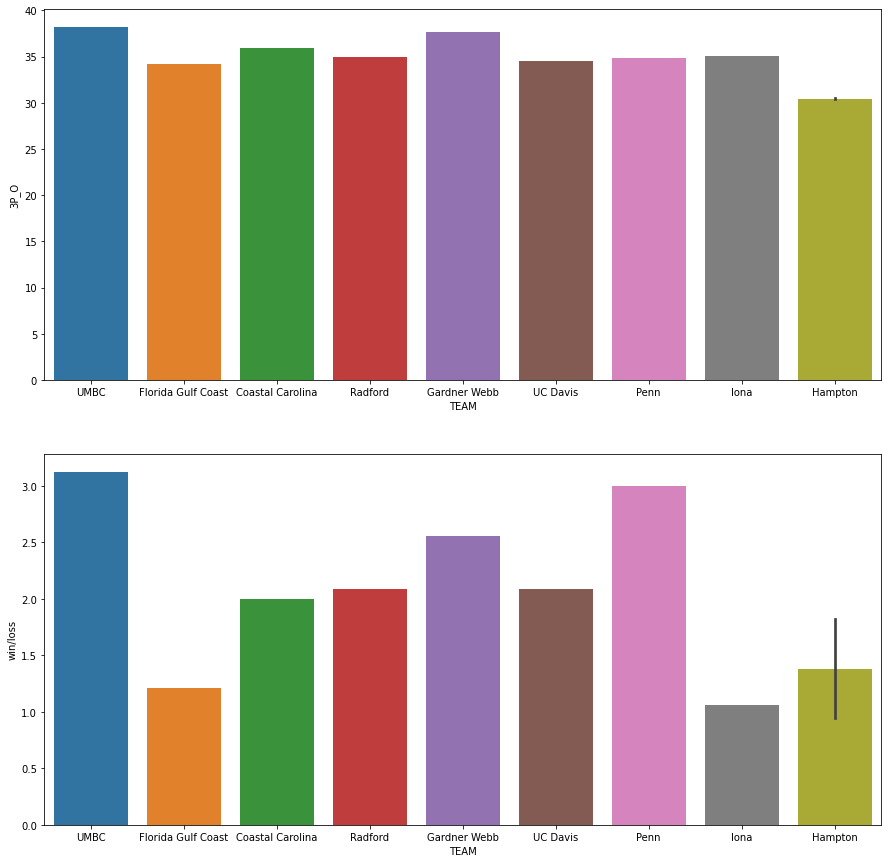

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(15,15))

ax = plt.subplot(2,1,1)
sns.barplot(data=top_10, x="TEAM", y="3P_O")

ax = plt.subplot(2,1,2)
sns.barplot(data=top_10, x="TEAM", y="win/loss")

<AxesSubplot:xlabel='YEAR', ylabel='W'>

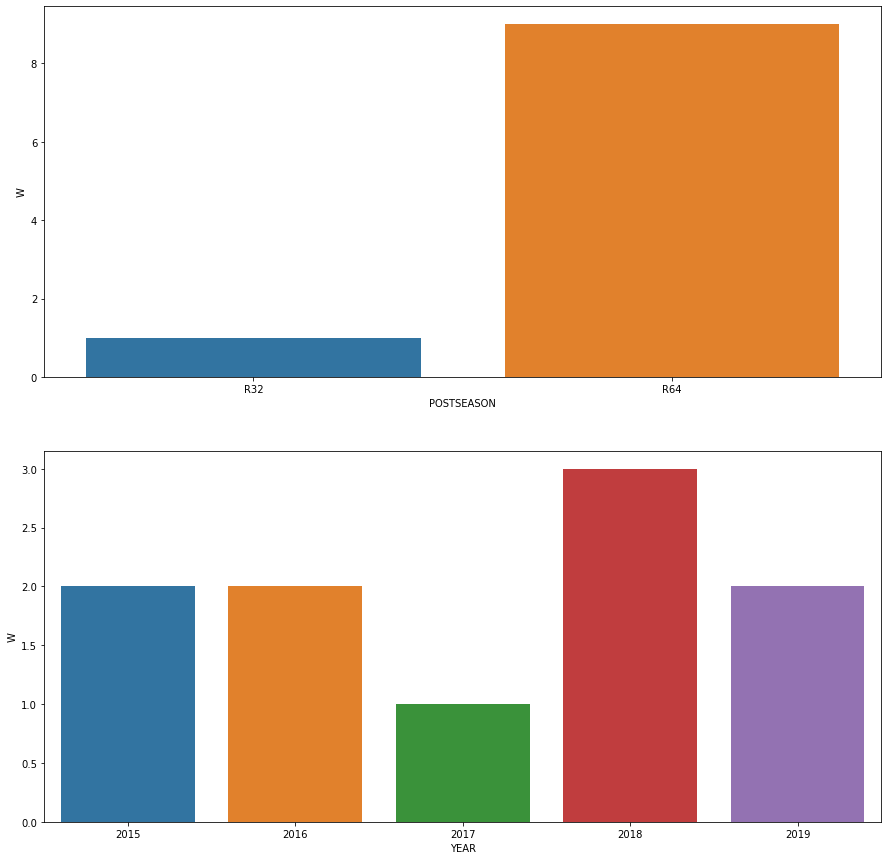

In [12]:
a = top_10.groupby('POSTSEASON').agg({'W':'count'}).reset_index()
b = top_10.groupby('YEAR').agg({'W':'count'}).reset_index()

fig, ax = plt.subplots(2, 1, figsize=(15,15))

ax = plt.subplot(2,1,1)
sns.barplot(data=a, x="POSTSEASON", y="W")

ax = plt.subplot(2,1,2)
sns.barplot(data=b, x="YEAR", y="W")

In [13]:
df2 = df[df['win/loss'] == 1.4285714285714286]
top_10_2 = df2.head(10)
top_10_2

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,win/loss
2068,Baylor,B12,34,20.0,114.6,99.2,0.8400,51.2,49.1,19.7,...,51.2,47.5,34.1,34.5,66.6,0.9,R32,9.0,2019,1.428571
2070,Oklahoma,B12,34,20.0,110.5,93.1,0.8780,50.4,47.5,17.0,...,49.7,45.8,34.6,33.3,70.3,2.5,R32,9.0,2019,1.428571
2163,Louisville,ACC,34,20.0,112.9,93.1,0.9023,50.9,46.7,17.5,...,50.6,46.0,34.2,32.0,68.6,2.3,R64,7.0,2019,1.428571
2164,Syracuse,ACC,34,20.0,110.5,94.2,0.8622,49.6,48.1,18.5,...,49.3,46.9,33.3,32.9,67.3,0.4,R64,8.0,2019,1.428571
2178,Indiana,B10,34,20.0,119.5,103.0,0.8473,54.4,50.3,17.2,...,50.2,50.9,40.6,32.5,67.2,-0.3,R64,10.0,2015,1.428571
2189,Texas,B12,34,20.0,110.3,90.7,0.9048,49.1,42.1,20.1,...,48.3,37.7,33.8,34.7,62.8,0.9,R64,11.0,2015,1.428571
2210,Seton Hall,BE,34,20.0,107.9,96.9,0.7749,49.9,49.6,17.5,...,50.6,48.7,32.4,34.0,70.4,-0.4,R64,10.0,2019,1.428571
2241,Iona,MAAC,34,20.0,108.8,107.6,0.5333,53.9,52.5,16.0,...,51.5,51.7,38.3,35.8,71.5,-7.3,R64,15.0,2018,1.428571
2248,Bradley,MVC,34,20.0,101.1,100.5,0.5170,49.7,47.6,18.8,...,46.5,46.5,37.0,32.8,66.5,-7.9,R64,15.0,2019,1.428571
2333,Milwaukee,Horz,34,20.0,104.3,103.9,0.5123,49.1,49.1,19.9,...,49.1,50.4,32.7,31.0,67.8,-6.1,R64,15.0,2014,1.428571


<AxesSubplot:xlabel='YEAR', ylabel='W'>

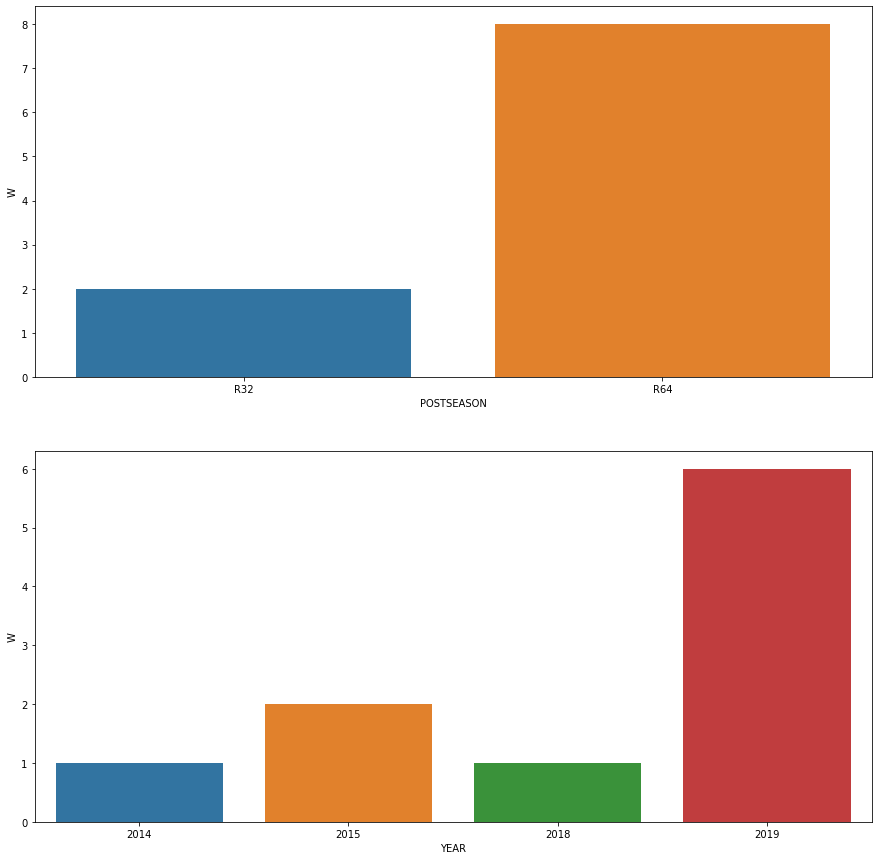

In [14]:
a1 = top_10_2.groupby('POSTSEASON').agg({'W':'count'}).reset_index()
b1 = top_10_2.groupby('YEAR').agg({'W':'count'}).reset_index()

fig, ax = plt.subplots(2, 1, figsize=(15,15))

ax = plt.subplot(2,1,1)
sns.barplot(data=a1, x="POSTSEASON", y="W")

ax = plt.subplot(2,1,2)
sns.barplot(data=b1, x="YEAR", y="W")